## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'as a synonym of type is deprecated')

from hparams import create_hparams
hparams = create_hparams()
hparams.batch_size = 4

In [5]:

import os

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
matplotlib.rc('text', usetex = True)
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
from mpl_toolkits.axes_grid1 import make_axes_locatable

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
from scipy.io import wavfile
import numpy as np
import torch
import torch.nn as nn

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from convert_model import update_model

from train import prepare_dataloaders
from torch.utils.data import DataLoader

In [6]:
import denoiser

#### Setup hparams

In [7]:
hparams = create_hparams()

#### Load model from checkpoint

In [9]:
# checkpoint_path = "tacotron2_statedict.pt"
checkpoint_path = 'sz296-4000-outdir/checkpoint_fat_4000'
if checkpoint_path.startswith('sz'):
    hparams.batch_size = 32
checkpoint_name = os.path.basename(checkpoint_path)
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

In [32]:
SAMPLE_RATE = 22050

PROJ_DIR = '/home/mcncm/class/6.867/proj'
OUT_DIR = os.path.join(PROJ_DIR, 'tacotron2/' + checkpoint_path.split('/')[0])
FIGS_DIR = os.path.join(PROJ_DIR, 'writeup/figures', checkpoint_name)
if not os.path.exists(FIGS_DIR):
    os.mkdir(FIGS_DIR)
AUDIO_DIR = os.path.join(PROJ_DIR, 'audio', checkpoint_name)
if not os.path.exists(AUDIO_DIR):
    os.mkdir(AUDIO_DIR)

fontsize=14

def plot_data(filename, data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

    
def plot_spectrograms(filename, specs, figsize=(16, 8), colorbar=False):
    fig, axes = plt.subplots(len(specs), 1, figsize=figsize)
    for i, (spec_name, spec) in enumerate(specs.items()):
        im = axes[i].imshow(spec, aspect='auto', origin='bottom', 
                       interpolation='none')
        
        if i < len(specs) - 1:  # turn of x labels on all but bottom plot
            axes[i].tick_params(
                axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)
        else:  # and put a label on the bottom plot
            axes[i].set_xlabel('Frame', fontsize=fontsize)
            axes[i].tick_params(axis='x', labelsize=fontsize)
            
        axes[i].set_ylabel('FFT bin', fontsize=fontsize)
        axes[i].set_yticks([0, spec.shape[0] - 1])
        axes[i].tick_params(axis='y', labelsize=fontsize)
        
        
        secax = axes[i].secondary_yaxis('right') #, functions=(forward, inverse))
        secax.set_ticks([])
        #secax.xaxis.set_minor_locator(AutoMinorLocator())
        secax.set_ylabel(spec_name, fontsize=fontsize)
    
    
    if colorbar:
        divider = make_axes_locatable(axes)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.savefig(os.path.join(FIGS_DIR, filename), bbox_inches='tight')
    plt.show()

def save_audio(filename, audio):
    def center(data):
        """Rescale to [0, 1]"""
        data -= np.max(data) + np.min(data)
        data = data/np.max(data)
        return data
        
    path = os.path.join(AUDIO_DIR, filename)
    audio = center(audio.astype(np.float32))
    wavfile.write(path, SAMPLE_RATE, audio)

In [11]:
def trim_spec(audio_data, threshold=-1e-7):
    r"""Find where data is last nonzero, then return up to that point
    """
    mins, _ = torch.min(audio_data, 0)
    return audio_data[:, (mins < threshold).nonzero().squeeze()]

#### Load WaveGlow for mel2audio synthesis and denoiser

In [13]:
waveglow_path = 'waveglow_256channels_ljs_v2.pt'
waveglow = update_model(torch.load(waveglow_path)['model']) 
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

### Stuff using `inference`.

In [14]:
train_loader, valset, collate_fn = prepare_dataloaders(hparams)

In [15]:
val_loader = DataLoader(valset, sampler=None, num_workers=1,
                        shuffle=False, batch_size=16,
                        pin_memory=False, collate_fn=collate_fn)
x, y = model.parse_batch(next(iter(val_loader)))

In [16]:
def infer_spec(x, y, i):
    r"""x: text inputs
        y: conditioning (reference) spectrograms
        i: batch index
    """
    res = model.inference(x[0][i,...].unsqueeze(0), y[0][0,...].unsqueeze(0))
    return res[1].data.squeeze()  # after postnet. res[0] is before-postnet.

In [ ]:
common_name = 'inference'

with torch.no_grad():
    for i in range(y[0].shape[0]):
        
        inferred_spec = infer_spec(x, y, i)
        true_spec = y[0][i,...]
        forward_spec = model(x)[0][i,...]
    
        specs = {'Inferred': inferred_spec, 'Forward': forward_spec, 'True': true_spec}
        for name, spec in specs.items():
            spec = trim_spec(spec)
            audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
            audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
            save_audio(common_name + "_{}".format(name.lower()) + "_{}".format(i) + '.wav', audio_data)

        for name, spec in specs.items():
            specs[name] = spec.cpu().numpy()
        
        plot_spectrograms(common_name + "_{}".format(i) + '.png',
                          specs,
                         figsize=(8, 4))

#plot_spectrogram("inference_test.png", get_spec(x, y, 2))

### Stuff using `forward`. (deprecated)

In [ ]:
y_pred = model(x)

common_name = 'new_model'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
specs = []
with torch.no_grad():
    for i in range(y_pred[0].shape[0]):
        spec = trim_spec(y_pred[0][i,...])
        specs.append(spec.cpu())
        audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec.float().data.cpu().numpy(),
                         figsize=(8, 4))


In [ ]:
y_pred_transfer = model(x, y[0][(1,2,3,0),...])

common_name = 'prosody_11k_steps_transfer'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
with torch.no_grad():
    for i in range(y_pred_transfer[0].shape[0]):
        spec_transfer = trim_spec(y_pred_transfer[0][i,...])
        audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec_transfer.float().data.cpu().numpy(),
                         figsize=(8, 4))

### Let's try perturbing the reference encodings.

In [ ]:
true_specs = [trim_spec(y[0][i,...]) for i in range(y[0].shape[0])]
embeddings = [model.reference_encoder(true_specs[i].unsqueeze(0)) for i in range(y[0].shape[0])]

#### Reference encoding PCA

`train_ref_encodings` should be a matrix of the reference encodings, such that
`train_ref_encodings[i,:]` contains the reference encoding for example i.

In [17]:
try:
    train_ref_encodings = np.load(os.path.join(OUT_DIR, "train_ref_encodings.npy"))
except:
    #hparams_big_batch = create_hparams()
    #hparams_big_batch.batch_size = 48
    #train_loader, valset, collate_fn = prepare_dataloaders(hparams_big_batch)
    train_ref_encodings = []
    for i, batch in enumerate(train_loader):
        if i % 10 == 0:
            print("batch number", i)
        x, y = model.parse_batch(batch)
        mels = x[2]
        encodings = model.ref_encoder(mels)  # TODO: replace with .inference
        train_ref_encodings.append(encodings.cpu().detach().numpy())
    train_ref_encodings = np.concatenate(train_ref_encodings)
    np.save(os.path.join(OUT_DIR, "train_ref_encodings.npy"), train_ref_encodings)

batch number 0
batch number 10
batch number 20
batch number 30
batch number 40
batch number 50
batch number 60
batch number 70
batch number 80
batch number 90
batch number 100
batch number 110
batch number 120
batch number 130
batch number 140
batch number 150
batch number 160
batch number 170
batch number 180
batch number 190
batch number 200
batch number 210
batch number 220
batch number 230
batch number 240
batch number 250
batch number 260
batch number 270
batch number 280
batch number 290
batch number 300
batch number 310
batch number 320
batch number 330
batch number 340
batch number 350
batch number 360
batch number 370
batch number 380


In [ ]:
try:
    val_ref_encodings = np.load(os.path.join(OUT_DIR, "val_ref_encodings.npy"))
except:
    #hparams_big_batch = create_hparams()
    #hparams_big_batch.batch_size = 48
    #train_loader, valset, collate_fn = prepare_dataloaders(hparams_big_batch)
    train_ref_encodings = []
    for i, batch in enumerate(val_loader):
        if i % 10 == 0:
            print("batch number", i)
        x, y = model.parse_batch(batch)
        mels = x[2]
        encodings = model.ref_encoder(mels)  # TODO: replace with .inference
        train_ref_encodings.append(encodings.cpu().detach().numpy())
    train_ref_encodings = np.concatenate(train_ref_encodings)
    np.save(os.path.join(OUT_DIR, "train_ref_encodings.npy"), train_ref_encodings)

Now let's actually calculate the singular value decomposition!

In [18]:
try:
    mean_encoding = np.load(os.path.join(OUT_DIR, "mean_encoding.npy"))
    train_u = np.load(os.path.join(OUT_DIR, "train_u.npy"))
    train_s = np.load(os.path.join(OUT_DIR, "train_s.npy"))
    train_vh = np.load(os.path.join(OUT_DIR, "train_vh.npy"))
except:
    mean_encoding = np.mean(train_ref_encodings, 0)
    centered_encodings = train_ref_encodings - mean_encoding
    train_u, train_s, train_vh = np.linalg.svd(centered_encodings)
    np.save(os.path.join(OUT_DIR, "mean_encoding.npy"), mean_encoding)
    np.save(os.path.join(OUT_DIR, "train_u.npy"), train_u)
    np.save(os.path.join(OUT_DIR, "train_s.npy"), train_s)
    np.save(os.path.join(OUT_DIR, "train_vh.npy"), train_vh)

In [19]:
random_matrix = np.random.normal(0, np.std(train_ref_encodings, 0),
                                 train_ref_encodings.shape)
rand_u, rand_s, rand_vh = np.linalg.svd(random_matrix)

And let's plot the spectrum of singular values.

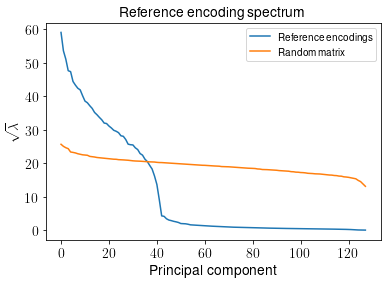

In [21]:
def plot_singular_values(filename, spectra, figsize=(6, 4)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    for name, sigmas in spectra.items():
        axes.plot(sigmas, label=name)
    axes.set_xlabel('Principal component', fontsize=fontsize)
    axes.set_ylabel(r'$\sqrt{\lambda}$', fontsize=fontsize)
    axes.legend()
    axes.set_title('Reference encoding spectrum', fontsize=fontsize)
    axes.tick_params(axis='both', which='major', labelsize=fontsize)
    axes.tick_params(axis='both', which='minor', labelsize=fontsize)
    fig.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()
    
plot_singular_values('ref_singular_values.png', {'Reference encodings': train_s, 'Random matrix': rand_s})

In [ ]:
### DEPRECATED 

def reconstruct_threshold(tau, s):
    r"""Estimate a matrix by singular value thresholding with cutoff tau."""
    return train_u @ cutoff_sigma_matrix(s, tau) @ train_u

def reconstruct_sigmas_list(sigma_indices, s, u, vh):
    r"""Estimate a matrix using the principal component indices in a list"""
    return sum((np.outer(s[i] * u[:,i], vh[i, :])
                for i in sigmas_list))

def reconstruct_sigmas_scaled(scalings, s, u, vh):
    r"""Estimate a matrix, rescaling the principal component indices in a list"""
    return reconstruct_sigmas_list(range(len(s)), scalings * s, u, vh)

def reconstruct_top_sigmas(n_sigmas):
    r"""Estimate a matrix using the _biggest_ singular values"""
    return reconstruct_sigmas_list(range(n_sigmas))

In [22]:
def rescale_principal_components(X, scalings, vh):
    r"""Copy the data points in X, rescale the principal components, and return
    """
    mean = torch.tensor(mean_encoding).cuda()
    vh = torch.tensor(vh).cuda()
    scalings = torch.tensor(scalings).cuda()
    return mean + ((X - mean) @ vh.transpose(0,1) @ torch.diag(scalings) @ vh)

def largest_n_principal_components(X, n, vh):
    r"""Using rescaling above, pick out the n largest principal components
    """
    scalings = np.zeros(X.shape[1], dtype=np.float32)
    scalings[:n] = 1
    return rescale_principal_components(X, scalings, vh)

### Little tools for hotswapping the encoder module

In [23]:
hparams.batch_size

32

In [24]:
class RandEncoder(nn.Module):
    def __init__(self, amplitude=5):
        super(RandEncoder, self).__init__()
        self.dimension = hparams.ref_embedding_dim
        self.amplitude = amplitude
    
    def forward(self, x):
        return self.amplitude * torch.rand(x.shape[0], self.dimension).cuda()


class RandPerturbationEncoder(nn.Module):
    def __init__(self, other, amplitude=5):
        super(RandPerturbationEncoder, self).__init__()
        self.dimension = hparams.ref_embedding_dim
        self.amplitude = amplitude
        self.other = other
    
    def forward(self, x):
        rand_vec = self.amplitude * (torch.rand(x.shape[0], self.dimension).cuda() - 0.5)
        return self.other(x) + rand_vec

    
class ClosureEncoder(nn.Module):
    r"""Takes a function as a parameter, calculates the 
    """
    def __init__(self, other, fn):
        super(ClosureEncoder, self).__init__()
        self.other = other
        self.fn = fn
    
    def forward(self, x):
        other_vec = self.other(x)
        return self.fn(other_vec)


class ZeroEncoder(nn.Module):
    def __init__(self):
        super(ZeroEncoder, self).__init__()
        self.dimension = hparams.ref_embedding_dim

    def forward(self, x):
        return torch.zeros(x.shape[0], self.dimension).cuda()


class EncoderContext():
    r"""Swap in a new encoder module on the fly with a `with` statement.
    """
    def __init__(self, model, encoder):
        self.model = model
        self.encoder = encoder
    
    def __enter__(self):
        self.old_encoder = self.model.ref_encoder
        self.model._modules['ref_encoder'] = self.encoder
    
    def __exit__(self, type, value, traceback):
        self.model._modules['ref_encoder'] = self.old_encoder

### Using these contexts

In [ ]:
def context_plots(common_name, encoder, max_plots=4, trim=True):
    r"""Use me to make plots of everything that happens with a given
    encoder context
    """
    with EncoderContext(model, encoder):
        with torch.no_grad():
            for i in range(y[0].shape[0]):
                if i >= max_plots:
                    break
        
                inferred_spec = infer_spec(x, y, i)
                true_spec = y[0][i,...]
                forward_spec = model(x)[0][i,...]
    
                specs = {'Inferred': inferred_spec, 'Forward': forward_spec, 'True': true_spec}
        
                min_len = max([spec.shape[1] for spec in specs.values()])
                
                for name, spec in specs.items():
                    spec = trim_spec(spec)
                    if trim:
                        spec = spec[..., :min_len - 1]
                    specs[name] = spec
                    audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
                    audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
                    save_audio(common_name + "_{}".format(name.lower()) + "_{}".format(i) + '.wav', audio_data)

                for name, spec in specs.items():
                    specs[name] = spec.cpu().numpy()
        
                plot_spectrograms(common_name + "_{}".format(i) + '.png',
                             specs,
                             figsize=(8, 4))

#### Native reference encoding vector

In [ ]:
context_plots('ref', ClosureEncoder(model.ref_encoder, lambda x: x))

#### Zeroed out reference encoding vector

In [ ]:
context_plots('zero', ZeroEncoder())

#### Random vectors

In [ ]:
context_plots('rand', RandEncoder(amplitude=1))

#### Scaling

In [ ]:
# context_plots('biggest', ClosureEncoder(model.ref_encoder, fn=lambda x: x ** 8 / torch.max(x) ** 7))

#### Scale the largest principal component

In [ ]:
scalings = np.ones(128, dtype=np.float32)
scalings[0] = 5
fn = lambda x: rescale_principal_components(x, scalings, train_vh)

context_plots('rescaling', ClosureEncoder(model.ref_encoder, fn=fn)) 

#### Zero vectors

## The results

In [25]:
def context_plots_encoders(common_name, encoders, sample_num=0, trim=True):
    r"""Use me to make plots of everything that happens with a given
    encoder context
    """
    
    with torch.no_grad():
        specs = {'True': y[0][sample_num,...]}

        for name, encoder in encoders.items():
            with EncoderContext(model, encoder):
                inferred_spec = infer_spec(x, y, sample_num)
                specs[name] = inferred_spec
    
        min_len = min([spec.shape[1] for spec in specs.values()])
                
        for name, spec in specs.items():
            spec = trim_spec(spec)
            if trim:
                spec = spec[..., :min_len - 1]
            specs[name] = spec
            audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
            audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
            save_audio(common_name + "_{}".format(name.lower()) + "_{}".format(sample_num) + '.wav', audio_data)

        for name, spec in specs.items():
            specs[name] = spec.cpu().numpy()
        
        plot_spectrograms(common_name + "_{}".format(sample_num) + '.png',
                         specs,
                         figsize=(14, 8))
    return specs

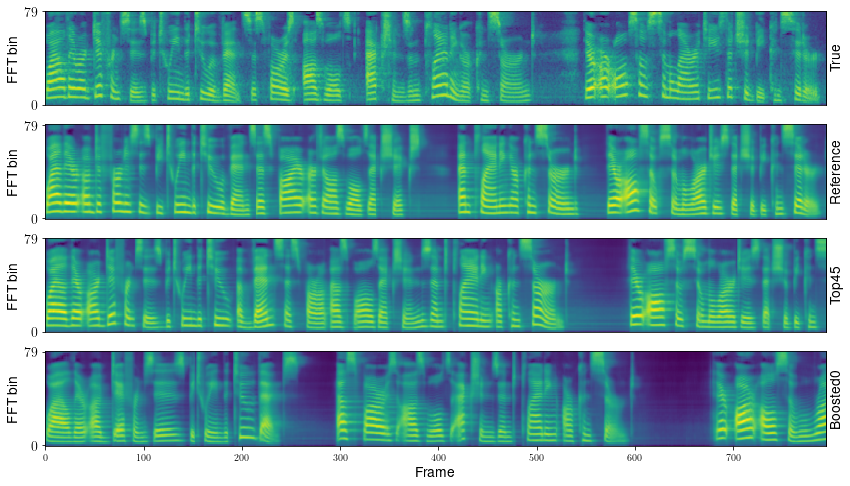

In [30]:
scalings = np.ones(128, dtype=np.float32)
i = 0
scalings[i] = 10

encoders = {'Reference': ClosureEncoder(model.ref_encoder, lambda x: x),
            'Top45': ClosureEncoder(model.ref_encoder, lambda x: largest_n_principal_components(x, 45, train_vh)),
            'Boosted{}'.format(i): ClosureEncoder(model.ref_encoder, lambda x: rescale_principal_components(x, scalings, train_vh))}

specs = context_plots_encoders('results', encoders)

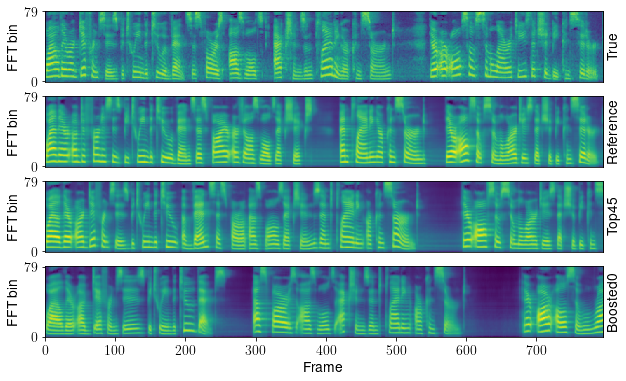

In [33]:
plot_spectrograms('results' + "_{}".format(0) + '.png',
                         specs,
                         figsize=(10, 6))

## MFCC thing

In [ ]:
import librosa

reference, sr = librosa.load(ref_wav)
predicted, sr = librosa.load(pred_wav)

n_mfcc = 13

ref_mfcc = librosa.feature.mfcc(y=reference, sr=sr, n_mfcc=n_mfcc)

pre_mfcc = librosa.feature.mfcc(y=predicted, sr=sr, n_mfcc=n_mfcc)

if (ref_mfcc.shape[1] > pre_mfcc.shape[1]):
    pad_length = ref_mfcc.shape[1] - pre_mfcc.shape[1]
    padding = np.zeros((n_mfcc, pad_length))
    pre_mfcc = np.c_[pre_mfcc, padding]
else:
    pad_length = pre_mfcc.shape[1] - ref_mfcc.shape[1]
    padding = np.zeros((n_mfcc, pad_length))
    ref_mfcc = np.c_[ref_mfcc, padding]
t = ref_mfcc.shape[1]
k = n_mfcc


ref_mfcc

outer_sum = 0
for t in range(0, t):
    inner_sum = 0
    for k in range(0, k):
        inner_sum = inner_sum + (ref_mfcc - pre_mfcc)**2
    outer_sum = outer_sum + np.sqrt(inner_sum)
mcd = outer_sum / t
print(mcd)


## Stuff from original inference.ipynb

#### Prepare text input

In [ ]:
text = "Institute has the finest professors."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [ ]:
plot_data('triple_spectrogram.png',
          (mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [ ]:
common_name = 'institute_5k_steps'

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    data = audio[0].data.cpu().numpy()
    save_audio(common_name + '.wav', data)

plot_spectrogram(common_name + '.png',
                 mel_outputs_postnet.float().data.cpu().numpy()[0],
                 figsize=(8, 4))

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
mel_outputs_postnet

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
#audio[0].data.cpu().numpy()
torch.__version__

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 